In [1]:
#@title
#@markdown *Copyright 2022 Google LLC*

#@markdown Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

# [https://www.apache.org/licenses/LICENSE-2.0](https://www.apache.org/licenses/LICENSE-2.0)

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title imports & utils
import io
import base64
import time
from functools import partial
from typing import NamedTuple
import subprocess

import PIL
import numpy as np
import matplotlib.pylab as pl

from IPython.display import display, Image, HTML

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def imshow(a, fmt='jpeg', display=display):
  return display(Image(data=imencode(a, fmt)))

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0):
    self.ffmpeg = None
    self.filename = filename
    self.fps = fps
    self.view = display(display_id=True)
    self.last_preview_time = 0.0

  def add(self, img):
    img = np.asarray(img)
    h, w = img.shape[:2]
    if self.ffmpeg is None:
      self.ffmpeg = self._open(w, h)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.ffmpeg.stdin.write(img.tobytes())
    t = time.time()
    if self.view and t-self.last_preview_time > 1:
       self.last_preview_time = t
       imshow(img, display=self.view.update)
    
  def __call__(self, img):
    return self.add(img)
    
  def _open(self, w, h):
    cmd = f'''ffmpeg -y -f rawvideo -vcodec rawvideo -s {w}x{h}
      -pix_fmt rgb24 -r {self.fps} -i - -pix_fmt yuv420p 
      -c:v libx264 -crf 20 {self.filename}'''.split()
    return subprocess.Popen(cmd, stdin=subprocess.PIPE, stderr=subprocess.PIPE)

  def close(self):
    if self.ffmpeg:
        self.ffmpeg.stdin.close()
        self.ffmpeg.wait()
        self.ffmpeg = None

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.filename == '_autoplay.mp4':
      self.show()

  def show(self):
      self.close()
      if not self.view:
        return
      b64 = base64.b64encode(open(self.filename, 'rb').read()).decode('utf8')
      s = f'''<video controls loop>
 <source src="data:video/mp4;base64,{b64}" type="video/mp4">
 Your browser does not support the video tag.</video>'''
      self.view.update(HTML(s))

def animate(f, duration_sec, fps=60):
  with VideoWriter(fps=fps) as vid:
    for t in jp.linspace(0, 1, int(duration_sec*fps)):
      vid(f(t))

In [3]:
#@title jax utils
import jax
import jax.numpy as jp

def norm(v, axis=-1, keepdims=False, eps=0.0):
  return jp.sqrt((v*v).sum(axis, keepdims=keepdims).clip(eps))

def normalize(v, axis=-1, eps=1e-20):
  return v/norm(v, axis, keepdims=True, eps=eps)

# Simple 3D visualization with JAX raycasting

[Alexander Mordvintsev](https://znah.net) | [Google](https://ai.google/) | September 23, 2022

<a href="https://colab.research.google.com/github/google-research/self-organising-systems/blob/master/notebooks/jax_raycast.ipynb" target="_blank" class="colab-root">Reproduce in a <span class="colab-span">Notebook</span></a>


Recently I was using JAX to model a few particles moving and interacting in 3D space. Naturally, at some point I wanted to see the behavior of these particles along with some information about their state and interactions with my own eyes. Visualization options available to a researcher are plentiful today, but in the spirit of minimalism I decided to build a visualization with the same tools I was using to make the model. What surprised me was: the effort it took to get a reasonable 3D rendering and the amount of code I had to write was comparable to the amount of code needed to integrate a traditional graphics framework. In principle, I got a working tool for simple 3D scene visualization.

The rendering approach I took is based on raycasting [Signed Distance Fields (SDF)](https://iquilezles.org/articles/distfunctions/). [Inigo Quilez](https://iquilezles.org/) popularized this approach and made [ShaderToy](https://www.shadertoy.com/), a thriving creative community of GPU shader developers. [Neural Rendering Fields](https://www.matthewtancik.com/nerf) and [Differentiable Rendering](https://www.youtube.com/watch?v=7LU0KcnSTc4) brought these ideas into machine learning world. There are a number of good SDF tutorials on the internet, including a [blog post](https://blog.evjang.com/2019/11/jaxpt.html) by Eric Jang, who also used JAX. I recommend having a look at them to get the basic understanding of SDF raycasting before reading further. In this tutorial I'd like to make emphasis on the simplicity and flexibility of using this approach in practice.

The scenes we’ll render consist of a few colored balls. I'm very excited about the underlying experiments which I originally set out to visualise, but that work is not yet ready for the publication, so let's generate some random dummies instead 😉

In [4]:
import jax
import jax.numpy as jp

class Balls(NamedTuple):
  pos: jp.ndarray
  color: jp.ndarray

def create_balls(key, n=16, R=3.0):
  pos, color = jax.random.uniform(key, [2, n, 3])
  pos = (pos-0.5)*R
  return Balls(pos, color)

key = jax.random.PRNGKey(123)
balls = create_balls(key)

Now we can define an SDF-function. For a given point `p` it returns a lower bound of the distance to the scene surface, positive for points outside of objects and negative inside. The function below computes distances from a given location to all balls and returns the minimum distance. We can use `jax.vmap` to sample many different locations in parallel, for example to quickly render 2D slices of a 3D SDF (see the <a href="https://colab.research.google.com/github/google-research/self-organising-systems/blob/master/notebooks/jax_raycast.ipynb#scrollTo=T4qykcQt8w4S" target="_blank">`show_slice`</a> function in the notebook linked at the top of the page). Other helper functions I'll use in this tutorial are L2-norm computation (`norm` and `normalize`) and `animate` to generate videos.

In [5]:
#@title (show_slice)
def show_slice(sdf, z=0.0, w=400, r=3.5):
  y, x = jp.mgrid[-r:r:w*1j, -r:r:w*1j].reshape(2, -1)
  p = jp.c_[x, y, x*0.0+z]
  d = jax.vmap(sdf)(p).reshape(w, w)
  pl.figure(figsize=(5, 5))
  kw = dict(extent=(-r, r, -r, r), vmin=-r, vmax=r)
  pl.contourf(d, 16, cmap='bwr', **kw );
  pl.contour(d, levels=[0.0], colors='black', **kw);
  pl.axis('equal')
  pl.xlabel('x')
  pl.ylabel('y')

(1000,)


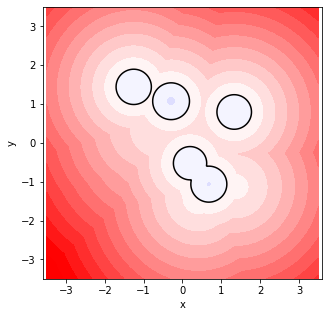

In [6]:
def balls_sdf(balls, p, ball_r=0.5):
  dists = norm(p-balls.pos)-ball_r
  return dists.min()

p = jax.random.normal(key, [1000, 3])
print( jax.vmap(partial(balls_sdf, balls))(p).shape )

show_slice(partial(balls_sdf, balls), z=0.0);

SDF raycasting makes it easy to achieve effects that are non-trivial to implement with traditional methods. For example, I would like to merge nearby balls to emphasize their interaction (the effect known as [metaballs](https://en.wikipedia.org/wiki/Metaballs)). With polygonal graphics this would require triangulating the isosurface (e.g. using [marching cubes](https://en.wikipedia.org/wiki/Marching_cubes) algorithm), but here we can smooth the balls by simply replacing the `min` function with a variant of [softmin](https://iquilezles.org/articles/smin/) (decreasing the parameter `c` makes smoothing stronger). Also I added a floor to the scene:

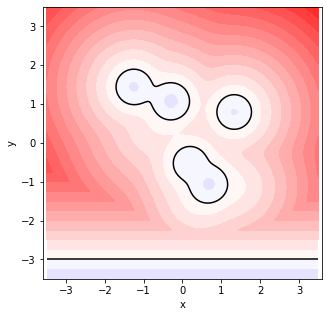

In [7]:
def scene_sdf(balls, p, ball_r=0.5, c=8.0):
  dists = norm(p-balls.pos)-ball_r
  balls_dist = -jax.nn.logsumexp(-dists*c)/c  # softmin
  floor_dist = p[1]+3.0  # floor is at y==-3.0
  return jp.minimum(balls_dist, floor_dist)  
  
show_slice(partial(scene_sdf, balls), z=0.0)

Raycasting SDFs is very easy to implement. Given a starting point `p0` and a unit-length ray direction `dir` we make a series of jumps, where the length of each jump equals the minimum distance to the surface. The function below returns the point that the ray reaches after `step_n` iterations. This point is supposed to be close to the scene surface for rays that hit it, and somewhere far away from the scene for rays that miss the surface.

In [8]:
def raycast(sdf, p0, dir, step_n=50):
  def f(_, p):
    return p+sdf(p)*dir
  return jax.lax.fori_loop(0, step_n, f, p0)

You may notice that I'm using `jax.lax.fori_loop` instead of a python loop. Otherwise, applying `@jax.jit` decorator to this function would cause the loop body, including all nested calls, to be unrolled `step_n` times. This would substantially slow down the compilation, and might be the reason for very long compilation times reported [in this post](​​https://blog.evjang.com/2019/11/jaxpt.html).

Another important limitation is the fixed number of loop steps. Unfortunately, JAX doesn't allow dynamic loops in jitted code (and later we’ll see that `jit` is really worth it when it comes to improving the rendering performance). In practice, some rays are going to escape the scene quickly, while others will quickly reach the surface. Only a fraction of surface-tangent rays would need that many steps. In GPU shader programming, groups of nearby rays are batched into blocks that are scheduled independently. Threads may have dynamic stopping conditions, so some blocks may finish earlier, releasing resources to work on slower blocks. The NumPy-inspired JAX (also TF and PyTorch) programming model is much less flexible in this regard.

Now when we can cast individual rays, we need to create a ray for each image pixel and cast them all together. `camera_rays` function calculates ray vectors given the camera direction, view size and field-of-view parameter.


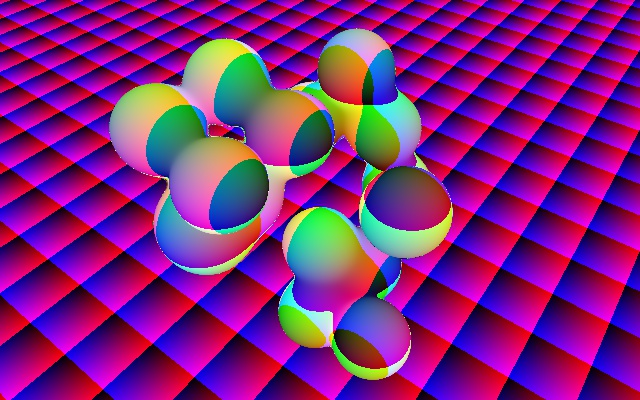

In [9]:
world_up = jp.array([0., 1., 0.])

def camera_rays(forward, view_size, fx=0.6):
  right = jp.cross(forward, world_up)
  down = jp.cross(right, forward)
  R = normalize(jp.vstack([right, down, forward]))
  w, h = view_size
  fy = fx/w*h
  y, x = jp.mgrid[fy:-fy:h*1j, -fx:fx:w*1j].reshape(2, -1)
  return normalize(jp.c_[x, y, jp.ones_like(x)]) @ R

w, h = 640, 400
pos0 = jp.float32([3.0, 5.0, 4.0])
ray_dir = camera_rays(-pos0, view_size=(w, h))
sdf = partial(scene_sdf, balls)
hit_pos = jax.vmap(partial(raycast, sdf, pos0))(ray_dir)
imshow(hit_pos.reshape(h, w, 3)%1.0)

Hoo**ray**, we can already see something! Ray endpoints are stored in the `hit_pos` array and the image above shows fractional parts of their XYZ coordinates as RGB colors.

## Shading and coloring

Our visual system is very good at estimating the shape of objects from the interplay of light and shadows, so shading is an important part of visualization. Whatever shading model we decide to apply, we have to know the surface normals in order to estimate how much light it receives and reflects. Luckly, SDFs and automated differentiation give us an easy way to get them: the normal is the gradient of the SDF function.

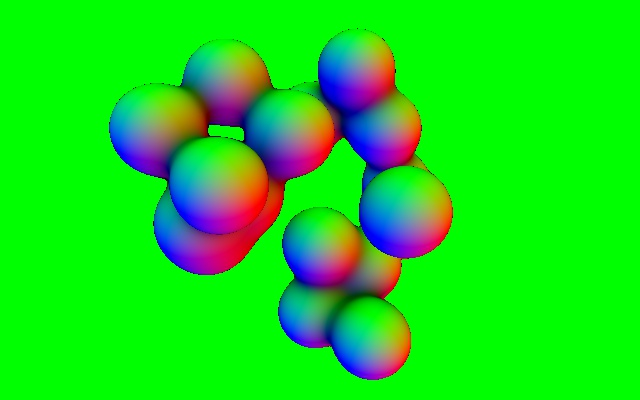

In [10]:
raw_normal = jax.vmap(jax.grad(sdf))(hit_pos)
imshow(raw_normal.reshape(h, w, 3))

You may notice that I saved the SDF gradient as `raw_normal`. The gradient of a perfect SDF function is a unit-length vector orthogonal to the isosurface at the current point. Our SDF is a little bit “imperfect” because of the ad-hoc smoothing with the soft-min function, which can make the gradient norm smaller than one in some areas. Shall we just correct this imperfection by "normalizing" normals and move on? There's something more interesting we can do! Let's look at the norms of our gradients:

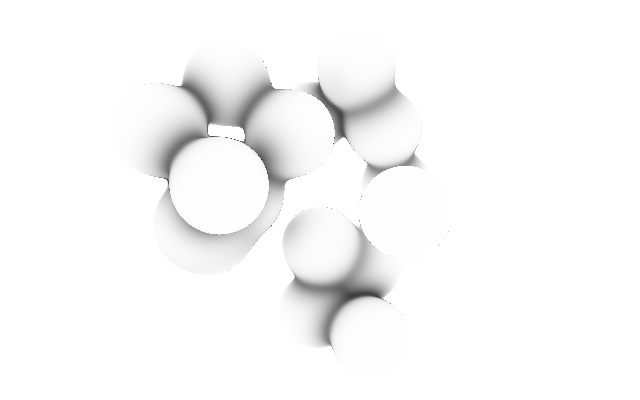

In [11]:
imshow(norm(raw_normal).reshape(h, w))


Gradient norms are smaller at concave areas of the surface. In real life, we have a phenomenon, that concave areas receive less ambient light because of occlusion, or are less shiny because they accumulate more dust over time. This gives a strong cue to our visual system, and the artifact of normal estimation gives us a way to approximately simulate this effect almost for free!

Direct light shadows are another important depth cue. We can simulate them by casting secondary rays from the surface towards the light source. Using SDFs we can even fake soft shadows with a single raycast. Please refer to this great [blog post](https://iquilezles.org/articles/rmshadows/) by Inigo Quilez for the details.


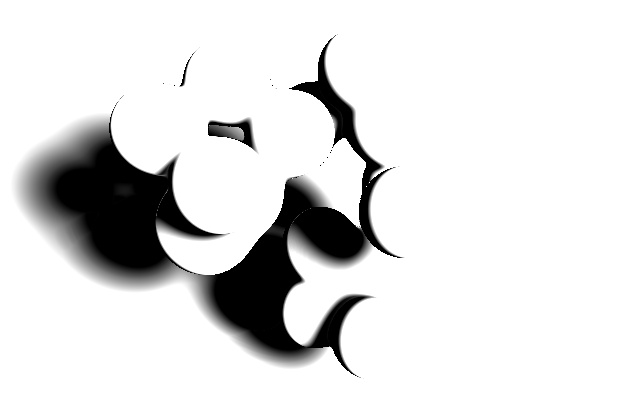

In [12]:
def cast_shadow(sdf, light_dir, p0, step_n=50, hardness=8.0):
  def f(_, carry):
    t, shadow = carry
    h = sdf(p0+light_dir*t)
    return t+h, jp.clip(hardness*h/t, 0.0, shadow)
  return jax.lax.fori_loop(0, step_n, f, (1e-2, 1.0))[1]

light_dir = normalize(jp.array([1.1, 1.0, 0.2]))
shadow = jax.vmap(partial(cast_shadow, sdf, light_dir))(hit_pos)
imshow(shadow.reshape(h, w))

Now let's apply all lighting components, including the classical [Blinn–Phong](https://en.wikipedia.org/wiki/Blinn%E2%80%93Phong_reflection_model) shading model. Note [gamma correction](https://developer.nvidia.com/gpugems/gpugems3/part-iv-image-effects/chapter-24-importance-being-linear) which is too often omitted even in professional software.

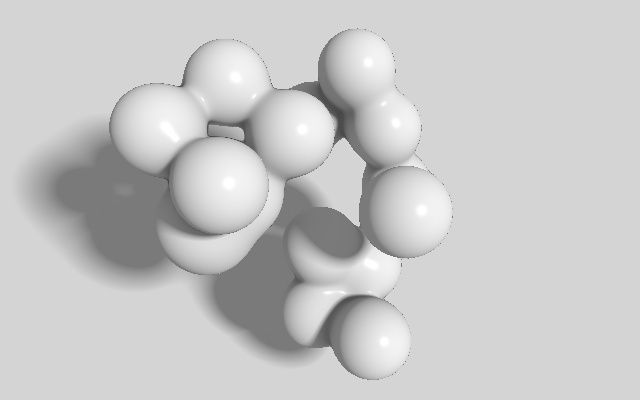

In [13]:
def shade_f(surf_color, shadow, raw_normal, ray_dir, light_dir):
  ambient = norm(raw_normal)
  normal = raw_normal/ambient
  diffuse = normal.dot(light_dir).clip(0.0)*shadow
  half = normalize(light_dir-ray_dir)
  spec = 0.3 * shadow * half.dot(normal).clip(0.0)**200.0
  light = 0.7*diffuse+0.2*ambient
  return surf_color*light + spec

f = partial(shade_f, jp.ones(3), light_dir=light_dir)
frame = jax.vmap(f)(shadow, raw_normal, ray_dir)
frame = frame**(1.0/2.2)  # gamma correction
imshow(frame.reshape(h, w, 3))

For now, all surfaces in our scene have a uniform white color, but shading allows us to interpret 3D geometry from a 2D image. Let's now add some colors and simple textures. I modified the scene function to have a special mode where it also returns the surface color. The function computes colors for both balls and the surface, and then uses `jp.choose` to select the color for the current pixel. The overhead for computing both colors is negligible because we use this mode only once per ray (versus the sdf-only mode, which we evaluate 50 times for primary and 50 times for shadow rays).

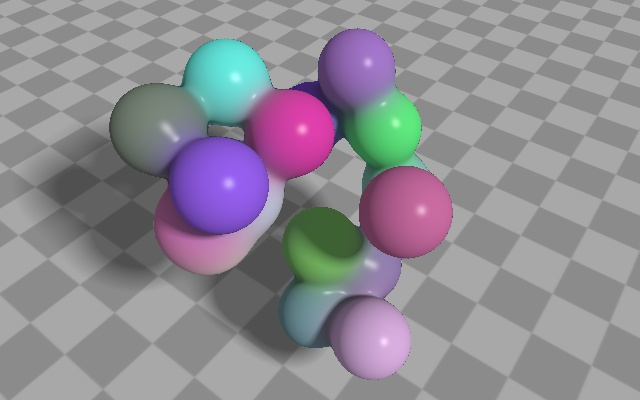

In [14]:
def scene_sdf(balls, p, ball_r=0.5, c=8.0, with_color=False):
  dists = norm(p-balls.pos)-ball_r
  balls_dist = -jax.nn.logsumexp(-dists*c)/c
  floor_dist = p[1]+3.0  # floor is at y==-3.0
  min_dist = jp.minimum(balls_dist, floor_dist)
  if not with_color:
    return min_dist
  x, y, z = jp.tanh(jp.sin(p*jp.pi)*20.0)
  floor_color = (0.5+(x*z)*0.1)*jp.ones(3)
  balls_color = jax.nn.softmax(-dists*c) @ balls.color
  color = jp.choose(jp.int32(floor_dist < balls_dist),
            [balls_color, floor_color], mode='clip')
  return min_dist, color

color_sdf = partial(scene_sdf, balls, with_color=True)
_, surf_color = jax.vmap(color_sdf)(hit_pos)
f = partial(shade_f, light_dir=light_dir)
frame = jax.vmap(f)(surf_color, shadow, raw_normal, ray_dir)
frame = frame**(1.0/2.2)  # gamma correction
imshow(frame.reshape(h, w, 3))

## Performance, animation, differentiation

That's it! With a moderate amount of code we got a shaded and colored scene. We rendered a single frame so far, but to create an animation we need to think about performance. JAX code can be made faster by using `@jit` decorator, which analyzes the flow of execution and generates the optimized code. Let's put everything together and JIT:

Compilation time:
CPU times: user 1.33 s, sys: 16.2 ms, total: 1.35 s
Wall time: 1.27 s


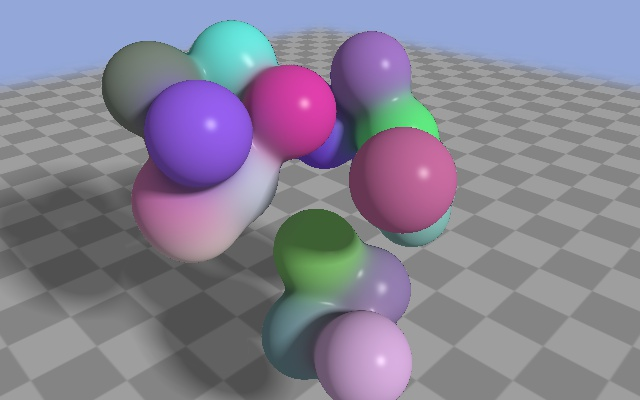

In [15]:
def _render_scene(balls,
                  view_size=(640, 400),
                  target_pos=jp.array([0.0, 0.0, 0.0]),
                  camera_pos=jp.array([4.0, 3.0, 4.0]),
                  light_dir=jp.array([1.5, 1.0, 0.0]),
                  sky_color=jp.array([0.3, 0.4, 0.7])):
  sdf = partial(scene_sdf, balls)
  normal_color_f = jax.grad(partial(sdf, with_color=True), has_aux=True)
  light_dir = normalize(light_dir)

  def render_ray(ray_dir):
    hit_pos = raycast(sdf, camera_pos, ray_dir)
    shadow = cast_shadow(sdf, light_dir, hit_pos)
    raw_normal, surf_color = normal_color_f(hit_pos)
    color = shade_f(surf_color, shadow, raw_normal, ray_dir, light_dir)
    escape = jp.tanh(jp.abs(hit_pos).max()-20.0)*0.5+0.5
    color = color + (sky_color-color)*escape
    return color**(1.0/2.2)  # gamma correction

  ray_dir = camera_rays(target_pos-camera_pos, view_size)
  color = jax.vmap(render_ray)(ray_dir)
  w, h = view_size
  return color.reshape(h, w, 3)

render_scene = jax.jit(_render_scene)

print('Compilation time:')
frame=%time render_scene(balls).block_until_ready()
imshow(frame)

The nested `render_ray` function computes the color of an individual pixel, so `vmap` is only applied once at the highest level. Rays that escape the scene are now colored with `sky_color`. I tried to use `jax.lax.cond` to skip shading these rays with conditional evaluation, but the performance I got (even for frames where most rays escaped) was even slightly worse than just evaluating everything and using algebra to select the resulting color. JAX [seems](https://github.com/google/jax/issues/2947) to execute both branches, which, along with the fixed number of steps per ray, is another limitation of tensor-granular API.

The first call to `render_scene` triggers JIT compilation, which takes around a second (wall time). Note that using `fori_loop` is critical to keep compilation times low. Using a python loop makes compilation ~10x slower.

Performance measurements of the original and the jitted function on a Colab Pro kernel can be seen below. I randomize ball positions each call to make sure that rendering results are not cached somewhere (doesn't seem to make any difference, but just in case).

In [16]:
def random_balls():
  key = jax.random.PRNGKey(np.random.randint(1e6))
  return create_balls(key)

!nvidia-smi -L
print('\nNo JIT render time:')
%timeit _render_scene(random_balls()).block_until_ready()
print('\nJIT render time:')
%timeit render_scene(random_balls()).block_until_ready()

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-93287726-bf2c-4c83-523a-c79a19482475)

No JIT render time:
594 ms ± 7.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

JIT render time:
15.3 ms ± 70.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We can see that JIT-compilation makes rendering a few tens of times faster! It is definitely worth the effort to make the code jit-compatible even if it means using fixed-size arrays and less convinient flow control. Our renderer can produce small frames (640x400) at interactive frame rates, so it shouldn't take long to generate an animation using the code we wrote. It would have been even faster if we were using GPU shader languages (e.g. GLSL) instead of JAX, because that would allow to terminate some rays early and release resources to work on harder rays.

Nevertheless, the approach described here has the benefit of using the same tools that are typically used to train differentiable models, so is perfectly viable e.g. for debugging and monitoring the training progress of simple particle systems. Let's make a little animation now.

In [19]:
%%time
pos = jp.float32([[1, 0], [0, 1], [2, 1], [2, 2.5], 
                  [4, 0], [4, 1.4], [5, 2.5], [6, 0], [6, 1.4],
                  [8, 0], [10, 0], [9, 1.2], [8, 2.4], [10, 2.4]])*0.7
color = jp.float32([[0.1,0.3,0.9]]*4 + [[0.01,0.4,0.3]]*5 + [[0.8,0.2,1.0]]*5)
pos = jp.c_[pos-pos.ptp(0)/2, 0.0*pos[:,:1]]
s0 = dict(
    balls=Balls(pos, color),
    camera_pos=jp.array([0.0,2.0, 7]),
    light_dir=jp.float32([1, 1, 1]))

keys = iter(jax.random.split(key, 10))
s1 = dict(
    balls=create_balls(next(keys), len(pos), R=10.0),
    camera_pos=jp.array([-15.0,8.0, -10]),
    light_dir=jp.float32([-5, 1, -1]))
s2 = dict(
    balls=create_balls(next(keys), len(pos), R=10.0),
    camera_pos=jp.array([15.0,9.0, -10]),
    light_dir=jp.float32([-3, 1, 1]))

def cubic(t, a, b, c, d):
  s = 1.0-t
  return s*s*(s*a + 3*t*b) + t*t*(3*s*c + t*d)

def render_frame(t):
  t = t*t*(3-2*t)  # easing
  s = jax.tree_map(partial(cubic, t), s0, s1, s2, s0)
  return render_scene(**s)

animate(render_frame, 10)

CPU times: user 12 s, sys: 1.41 s, total: 13.4 s
Wall time: 16.8 s


The code above uses `jax.tree_map` to conveniently interpolate between nested data structures that contain information about the scene, including light and camera position.

Rendering a 10 second 60 fps animation takes from ~20 to less than 10 seconds depending on the available GPU (I tried V100 and A100, also running the first time in a Colab session takes a bit longer). Not bad for a ~100 lines of code engine built from scratch on top of the generic array processing language.

Oh, and did I mention that all JAX autodiff and vectorization goodies are still applicable? For example, nothing stops us from using forward AD to compute temporal derivatives of pixel color values, and then use them to make linear approximations of video frames around a particular moment of time. Note how adding and subtracting derivatives creates the illusion of motion, especially around specular highlights.


In [18]:
img, dimg = jax.jvp(render_frame, (0.005,), (0.5,))
animate(lambda t: img+jp.sin(8*t*jp.pi)*t*dimg, 3)

## Conclusion

I hope you enjoyed this little tutorial. Demosceners and shader developers probably wouldn't be impressed, but I hope it makes more ML developers aware of some less usual applications and capabilities of their tools.

Below you can find a few pointers to resources related to *SDF ray tracing* and *Differentiable Rendering* (and searching for these terms would give you many more).

* [Articles](https://iquilezles.org/articles/) and [YouTube channel](https://www.youtube.com/Inigo_Quilez) by [Inigo Quilez](https://iquilezles.org/)
* [ShaderToy](https://www.shadertoy.com/)
* [Differentiable Path Tracing on the GPU/TPU](https://blog.evjang.com/2019/11/jaxpt.html)
* [Implementing NeRF in JAX](https://wandb.ai/wandb/nerf-jax/reports/Implementing-NeRF-in-JAX--VmlldzoxODA2NDk2)


### Acknowledgements
I'd like to thank my colleagues Johannes Oswald, Eyvind Niklasson and Ettore Randazzo for feedback and proofreading.